In [204]:
import statsmodels.api as sm
import sklearn.linear_model
import sklearn.model_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statutils

plt.rcParams['figure.figsize'] = (20, 10)

<br>

How well does a linear regression fit unrelated data when $ N_{samples} - N_{variables} << N_{variables} $

In [230]:
N = 1000
n = 950

X = np.random.normal(size=(N, n))
y = np.random.normal(size=(N,))

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):             -0.081
Method:                 Least Squares   F-statistic:                             0.9213
Date:                Mon, 20 Dec 2021   Prob (F-statistic):                       0.679
Time:                        20:53:15   Log-Likelihood:                          19.290
No. Observations:                1000   AIC:                                      1861.
Df Residuals:                      50   BIC:                                      6524.
Df Model:                         950                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [235]:
result.predict(X).shape

(1000,)

In [236]:
resid = result.predict(X) - y
mse, ystd = np.linalg.norm(resid)**2/N, y.std()**2
r_sqrd = 1 - (mse/ystd)
mse, r_sqrd

(0.056334047709508034, 0.9459572524634204)

In [231]:
mse, ystd = np.linalg.norm(result.resid)**2/N, y.std()**2
r_sqrd = 1 - (mse/ystd)
mse, r_sqrd

(0.056334047709508034, 0.9459572524634204)

<br>

#### What is the relationship between $ N_{variables}/N_{samples} $ and $MSE$ when there is no relationship between $X$ and $y$? 

Define different distributions for the unrelated $X, y$

In [124]:
# X ~ normal, y ~ normal
def get_samples(N, n):
    X = np.random.normal(size=(N, n))
    y = np.random.normal(size=(N,))
    return X,y 

In [125]:
# X ~ binomial, y ~ binomial
def get_samples(N, n):
    X = np.random.binomial(30, 0.9654746681256314, size=(N, n))
    y = np.random.binomial(30, 0.9654746681256314, size=(N,))
    return X,y 

In [126]:
# X ~ poisson, y ~ poisson
def get_samples(N, n):
    X = np.random.poisson(1, size=(N, n))
    y = np.random.poisson(1, size=(N,))
    return X,y 

In [127]:
# X ~ poisson, y ~ binomial
def get_samples(N, n):
    X = np.random.poisson(1, size=(N, n))
    y = np.random.binomial(30, 0.9654746681256314, size=(N,))
    return X,y 

<br>

Run experiments

In [128]:
# run many linear models of overdetermined linear systems
# use N_samples ~ uniform(min_samp, max_samp)
# use N_variables ~ uniform(1, N_samples)
# generate unrelated X, y where X is (N_samples x N_variables)
# compute (N_variables/N_samples, MSE)

# how many experiments to run
N_iter = 1000

# sample size
max_samp = 300
min_samp = 2

# results ~ [ (N_variables/N_samples, MSE), ... ]
results = list()

for i in range(N_iter):

    if (i%10 == 0):
        print(f'\r{round(100*i/N_iter, 2)}%', end='')
    
    N = np.random.randint(min_samp, max_samp)
    n = np.random.randint(1, N)

    X,y = get_samples(N, n)

    model = sm.OLS(y, X)
    result = model.fit()

    mse = np.linalg.norm(result.resid)**2/N
    r_sqd = mse/(y.std()**2)

    results.append({
        "N" : N,
        "n" : n,
        "n/N" : n/float(N),
        "MSE" : mse,
        "R^2" : r_sqd
    })

df = pd.DataFrame(results)
df.head()

62.0%

<ipython-input-128-3a51982f91d7>:31: RuntimeWarning: divide by zero encountered in double_scalars
  r_sqd = mse/(y.std()**2)


99.0%

,N,n,n/N,MSE,R^2
0,121,12,0.099174,66.858575,60.105391
1,25,10,0.400000,49.010238,73.988886
2,27,8,0.296296,51.793163,58.088025
3,196,58,0.295918,8.520261,8.811327
4,195,160,0.820513,1.508814,1.385612


In [129]:
# smooth results
xh, yh, errs = statutils.gaussian_filter(df['n/N'].values, df['MSE'].values, nx=1000, sigma=0.02, nsigma=20)

Text(0, 0.5, 'MSE')

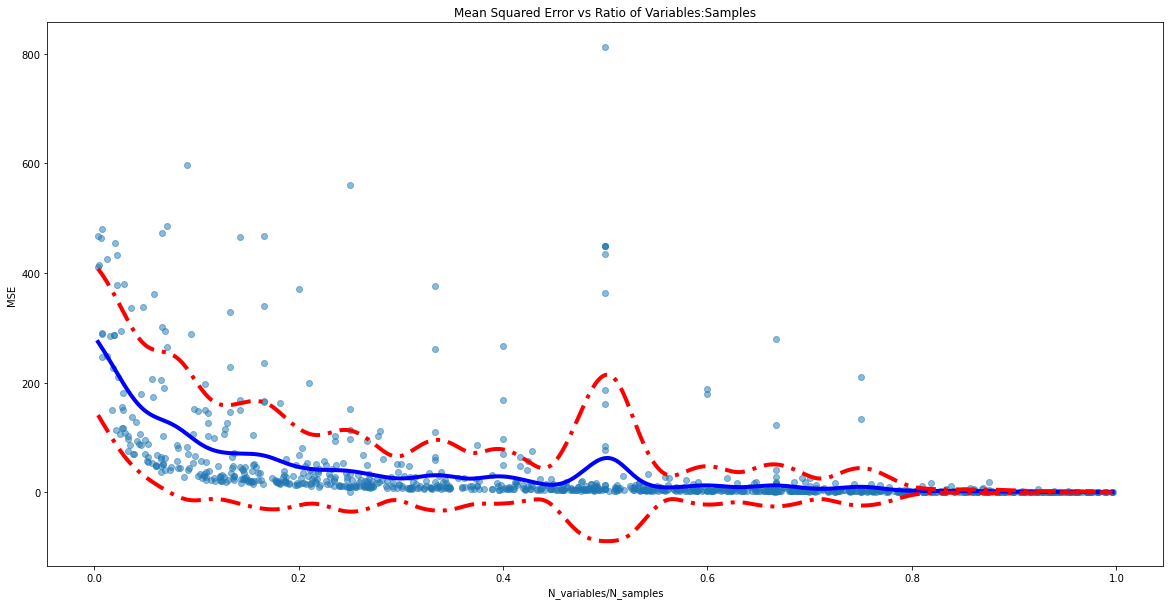

In [130]:
dashed_style = (0, (5, 2, 1, 2))
lwidth = 4

plt.plot(xh, yh, color='b', linewidth=lwidth)
plt.plot(xh, yh+errs, color='r', linewidth=lwidth, linestyle=dashed_style)
plt.plot(xh, yh-errs, color='r', linewidth=lwidth, linestyle=dashed_style)
plt.scatter(df['n/N'], df['MSE'], alpha=0.5)
plt.title('Mean Squared Error vs Ratio of Variables:Samples')
plt.xlabel('N_variables/N_samples')
plt.ylabel('MSE')

<br>

#### Suppose there is a relationship between X and y

In [328]:
USE_SKLEARN = True
HAS_RELATION = True
ERROR_SIGMA = 1

res = list()

# for each generated dataset, how many cross validation iterations?
cross_val_n = 2

# how many experiments to run
N_iter = 3000

# sample size
max_samp = 200
min_samp = 20

for i in range(N_iter):

    if (i%10 == 0):
        print(f'\r{round(100*i/N_iter, 2)}%', end='')
    
    N = np.random.randint(min_samp, max_samp)
    n = np.random.randint(1, N)

    beta = np.random.normal(size=(n,))
    X = np.random.normal(size=(N, n))

    if HAS_RELATION:
        y = X.dot(beta) + ERROR_SIGMA*np.random.normal(size=(N,))
    else:
        y = ERROR_SIGMA*np.random.normal(size=(N,))

    for j in range(cross_val_n):

        xtr, xte, ytr, yte = sklearn.model_selection.train_test_split(X, y, test_size=np.random.randint(.1*N, .9*N)/N)

        if USE_SKLEARN:
            # sklearn
            model = sklearn.linear_model.LinearRegression(fit_intercept=False)
            model.fit(xtr, ytr)
            yhtr = model.predict(xtr)
            yhte = model.predict(xte)

        else:
            # stats models
            model = sm.OLS(ytr, xtr)
            result = model.fit()
            yhtr = result.predict(xtr)
            yhte = result.predict(xte)

        N_tr = len(ytr)
        is_mse = np.linalg.norm(yhtr - ytr)**2/N_tr
        oos_mse = np.linalg.norm(yhte - yte)**2/len(yte)

        oos_rsqd = 1 - (oos_mse/yte.std()**2)
        is_rsqd = 1 - (is_mse/ytr.std()**2)

        res.append({
            "n" : n,
            "N" : N_tr,
            "n/N" : n/N_tr,
            "OOS_MSE" : oos_mse,
            "IS_MSE" : is_mse,
            "OOS_RSQD" : oos_rsqd,
            "IS_RSQD" : is_rsqd
        })
        
df = pd.DataFrame(res)
df.head()

99.67%

,n,N,n/N,OOS_MSE,IS_MSE,OOS_RSQD,IS_RSQD
0,1,11,0.090909,0.866665,6.473788e-01,0.445821,0.356856
1,1,31,0.032258,0.799965,6.462163e-01,0.472282,0.551336
2,69,42,1.642857,21.147345,1.244517e-28,0.606816,1.000000
3,69,40,1.725000,28.409926,3.241852e-28,0.481094,1.000000
4,47,80,0.587500,2.529597,4.618305e-01,0.951132,0.988103


In [329]:
is_obj, oos_obj = 'IS_MSE', 'OOS_MSE'

In [330]:
# smooth results
sigma, nsigma = 0.15, 20
xh, yh, errs = statutils.gaussian_filter(df['n/N'].values, df[oos_obj].values, nx=1000, sigma=sigma, nsigma=nsigma)
xhi, yhi, errsi = statutils.gaussian_filter(df['n/N'].values, df[is_obj].values, nx=1000, sigma=sigma, nsigma=nsigma)

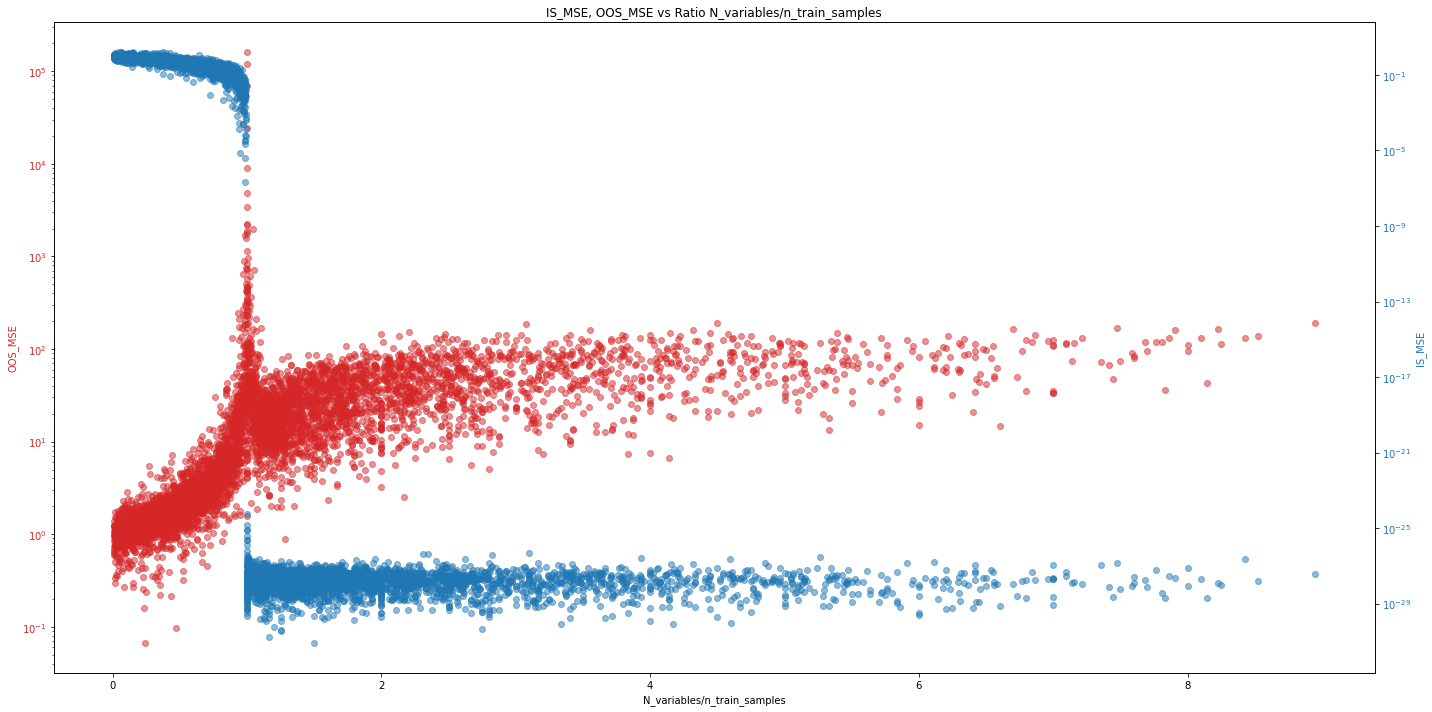

In [334]:
dashed_style = (0, (5, 2, 1, 2))
lwidth = 4

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.set_yscale('log'), ax2.set_yscale('log')

# plot out of sample error
color = 'tab:red'
ax1.set_xlabel('N_variables/n_train_samples')
ax1.set_ylabel(oos_obj, color=color)
ax1.scatter(df['n/N'], df[oos_obj], color=color, alpha=0.5)


ax1.tick_params(axis='y', labelcolor=color)

# plot in sample error
color = 'tab:blue'
ax2.set_ylabel(is_obj, color=color)  # we already handled the x-label with ax1
ax2.scatter(df['n/N'], df[is_obj], color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'{is_obj}, {oos_obj} vs Ratio N_variables/n_train_samples')

# # plot smoothed relation
# ax1.plot(xh, yh, color='k'), ax2.plot(xhi, yhi, color='g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped